In [1]:
# dataDir = "/home/ababil/BUET/AV/csv"
dataDir = "D:/AV/Code/location-2"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2"

In [2]:
exec(open('init_notebook.py').read())

current working dirD:\AV\Code\behavior-hypotheses\src


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper

In [5]:
sceneId = 210
sceneId2 = 211
date = "2023-05-04"
fps=10
minYDisplacement = 5
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
pedDf2 = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId2}-pedestrians.csv"))
# otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

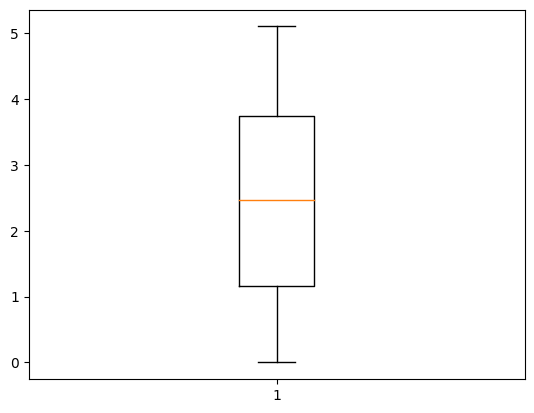

{'whiskers': [<matplotlib.lines.Line2D at 0x2634d7b46a0>,
 'caps': [<matplotlib.lines.Line2D at 0x2634d7b4be0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2634d7a7190>],
 'medians': [<matplotlib.lines.Line2D at 0x2634d7c6160>],
 'fliers': [<matplotlib.lines.Line2D at 0x2634d7c6400>],
 'means': []}

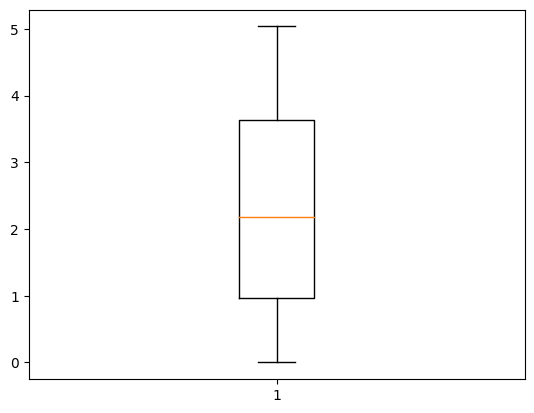

In [6]:
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity', 
        speedCol='speed',
        xAccCol='sceneXAcceleration',
        yAccCol='sceneYAcceleration',
        accelerationCol='acceleration'
        
    
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    minAcceleration = -10.0,
    maxAcceleration = 10.0,
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
transformer.deriveAcceleration(pedDf)

transformer.deriveSpeed(pedDf2)
transformer.deriveDisplacements(pedDf2)
transformer.deriveAcceleration(pedDf2)

plt.boxplot(pedDf['displacementY'])
plt.show()
plt.boxplot(pedDf2['displacementY'])

In [7]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate(trackDf)
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


using min Y displacement (5)


7600

{'whiskers': [<matplotlib.lines.Line2D at 0x2635434fa30>,
 'caps': [<matplotlib.lines.Line2D at 0x2635434faf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2635434f790>,
 'medians': [<matplotlib.lines.Line2D at 0x26354361070>,
 'fliers': [<matplotlib.lines.Line2D at 0x26354361310>,
 'means': []}

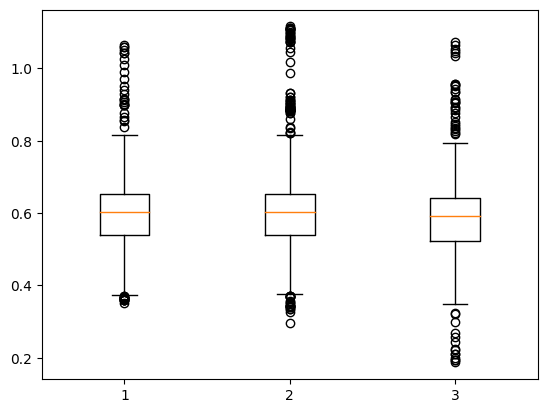

In [40]:

startingDf = cleanPedDf[cleanPedDf["displacementY"] < 1].copy()
midDf = cleanPedDf[(cleanPedDf["displacementY"] >= 1) & (cleanPedDf["displacementY"] < 4)].copy()
endDf = cleanPedDf[(cleanPedDf["displacementY"] >= 4)].copy()

# fig, (bx1, bx2, bx3) = plt.subplots(1, 3)
# fig.suptitle('Horizontally stacked subplots')
list1 = [startingDf['speed'], midDf['speed'], endDf['speed']]
# bx1.boxplot(startingDf['speed'])
# bx2.boxplot(midDf['speed'])
# bx3.boxplot(endDf['speed'])

plt.boxplot(list1)
# bx1.set_xticklabels('speed')
# bx2.set_xticklabels('speed')
# bx3.set_xticklabels('speed')

The speed is divided into categories and is denoted as buckets. Each bucket has equal speed range.

In [9]:
# cleanPedDf_copy = cleanPedDf.copy()
# # cleanPedDf_copy.head(10)

# NO_OF_CATEGORY = 3

# MIN_SPEED = cleanPedDf_copy["speed"].min()
# MAX_SPEED = cleanPedDf_copy["speed"].max()

# def assign_category(value, min_value, max_value, no_of_category = NO_OF_CATEGORY):
#     bucket_range = math.ceil(max_value - min_value) / no_of_category
    
#     for i in range(no_of_category):
#         if ((i-1)*bucket_range < value) and ((i*bucket_range) >= value):
#                 return i
    
    
# # cleanPedDf_copy["Bucket"] = cleanPedDf_copy["speed"].apply(assign_category(MIN_SPEED, MAX_SPEED))
# cleanPedDf_copy["Bucket"] = assign_category(cleanPedDf_copy["speed"], min_speed, max_value, NO_OF_CATEGORY)

# cleanPedDf_copy.head(10)

In [10]:
cleanPedDf_copy = cleanPedDf.copy()
cleanPedDf_copy.head(10)
print(len(cleanPedDf_copy), len(cleanPedDf))

NO_OF_CATEGORY = 3

def assign_category(value_column, num_categories):
    min_value = value_column.min()
    max_value = value_column.max()
    value_range = max_value - min_value
    category_range = value_range / num_categories
    
    def categorize(speed):
        category = int((speed - min_value) / category_range)
        return min(category, num_categories - 1)
    
    categories = value_column.apply(categorize)
    return categories

# Example usage:
min_value = cleanPedDf_copy["speed"].min()
max_value = cleanPedDf_copy["speed"].max()
value_range = max_value - min_value
category_range = value_range / NO_OF_CATEGORY
print(f"Range in one bucket: {category_range}")

# Assuming cleanPedDf_copy is your DataFrame
cleanPedDf_copy["Bucket"] = assign_category(cleanPedDf_copy["speed"], NO_OF_CATEGORY)
print("Buckets:", cleanPedDf_copy["Bucket"].min(), cleanPedDf_copy["Bucket"].max())

cleanPedDf_copy.head(10)


7600 7600
Range in one bucket: 0.30947310850614834
Buckets: 0 2


,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,Bucket
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,0
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,0
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,0
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,0
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,0
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023,0
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184,0
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701,0
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228,0
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489,1


In [11]:
# Find the minimum and maximum values
min_value = cleanPedDf_copy["speed"].min()
max_value = cleanPedDf_copy["speed"].max()

# Print the results
print(f"Minimum: {min_value}")
print(f"Maximum: {max_value}")

Minimum: 0.18725550726214213
Maximum: 1.1156748327805872


In [12]:
# Boolean indexing to filter rows
selected_rows = cleanPedDf_copy[cleanPedDf_copy["speed"] < category_range]

# Print the selected rows
selected_rows

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,Bucket
1325,18,20704,18313,210,5.0,1.023349,0.656938,0.005271,0.296247,-0.007759,-0.124922,0.296293,0.393950,1.797915,0.125162,-0.000000,-0.000000,0
5347,20,31156,20475,210,5.0,0.865716,-1.816160,-0.055291,0.292684,-0.005183,0.121831,0.297860,0.236316,4.271013,0.121941,-0.685787,4.313185,0
5348,20,31158,20475,210,5.0,0.876601,-1.868859,-0.054425,0.263495,-0.004331,0.145943,0.269057,0.247201,4.323712,0.146007,-0.696672,4.365885,0
5349,20,31160,20475,210,5.0,0.887647,-1.916396,-0.055234,0.237686,0.004046,0.129047,0.244019,0.258248,4.371250,0.129111,-0.707718,4.413422,0
5350,20,31162,20475,210,5.0,0.899068,-1.959400,-0.057104,0.215021,0.009351,0.113326,0.222474,0.269668,4.414254,0.113711,-0.719139,4.456426,0
5351,20,31164,20475,210,5.0,0.911042,-1.999649,-0.059871,0.201244,0.013832,0.068882,0.209961,0.281642,4.454503,0.070257,-0.731113,4.496675,0
5352,20,31166,20475,210,5.0,0.923519,-2.036241,-0.062381,0.182963,0.012552,0.091408,0.193305,0.294119,4.491095,0.092266,-0.743590,4.533267,0
5353,20,31168,20475,210,5.0,0.937073,-2.071153,-0.067773,0.174561,0.026962,0.042010,0.187256,0.307673,4.526007,0.049918,-0.757144,4.568179,0
5354,20,31170,20475,210,5.0,0.951749,-2.106942,-0.073376,0.178940,0.028013,-0.021898,0.193400,0.322349,4.561795,0.035556,-0.771819,4.603967,0
5355,20,31172,20475,210,5.0,0.967229,-2.143691,-0.077403,0.183747,0.020136,-0.024035,0.199385,0.337829,4.598545,0.031355,-0.787300,4.640717,0


In [13]:
# Find the minimum and maximum values
min_value = cleanPedDf_copy["sceneYAcceleration"].min()
max_value = cleanPedDf_copy["sceneYAcceleration"].max()

# Print the results
print(f"Minimum: {min_value}")
print(f"Maximum: {max_value}")

Minimum: -0.3269453639165087
Maximum: 0.2355728036146587


The acceleration is divided into positive and negative categories and is denoted as accBuckets. Positive and negative acceleration have same number of accBuckets. The range of positive and negative acceleration is different.

In [14]:
# def assign_acc_category(acc):
#     if acc < 0.1:
#         # print("A")
#         return 1
#     elif (acc >= 0.1) & (acc < 2*0.1):
#         return 2
#     else:
#         return 3
    
# cleanPedDf_copy["accBucket"] = cleanPedDf_copy["acceleration"].apply(assign_acc_category)
# cleanPedDf_copy.head(10)

NO_OF_CATEGORY = 3

min_value = cleanPedDf_copy["sceneYAcceleration"].min()
max_value = cleanPedDf_copy["sceneYAcceleration"].max()
value_range = max_value - min_value
category_range = value_range / NO_OF_CATEGORY

def assign_category_acc(value_column, num_categories):
    min_value = value_column.min()
    max_value = value_column.max()
    # value_range = max_value - min_value
    pos_category_range = max_value / num_categories
    print(f"Pos Cat Range = {pos_category_range}")
    neg_category_range = -(min_value) / num_categories
    print(f"Neg Cat Range = {neg_category_range}")

    
    def categorize(acc):
        if acc > 0:
            category = int(acc / pos_category_range)
            return min(category, num_categories - 1)
        else:
            category = int(acc / neg_category_range)
            return max(category - 1, -num_categories)
    
    categories = value_column.apply(categorize)
    return categories

# Assuming cleanPedDf_copy is your DataFrame
cleanPedDf_copy["accBucket"] = assign_category_acc(cleanPedDf_copy["sceneYAcceleration"], NO_OF_CATEGORY)

print("accBucket:", cleanPedDf_copy["accBucket"].min(), cleanPedDf_copy["accBucket"].max())

cleanPedDf_copy.head(10)

Pos Cat Range = 0.07852426787155291
Neg Cat Range = 0.10898178797216956
accBucket: -3 2


,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,Bucket,accBucket
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,0,-1
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,0,0
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,0,-1
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,0,-1
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,0,0
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023,0,0
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184,0,0
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701,0,-1
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228,0,-1
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489,1,-1


In [15]:

# firstDf = cleanPedDf[cleanPedDf["speed"] < 1].copy()
# secondDf = cleanPedDf[(cleanPedDf["speed"] >= 1) & (cleanPedDf["speed"] < 2)].copy()
# thirdDf = cleanPedDf[(cleanPedDf["speed"] >= 2)].copy()


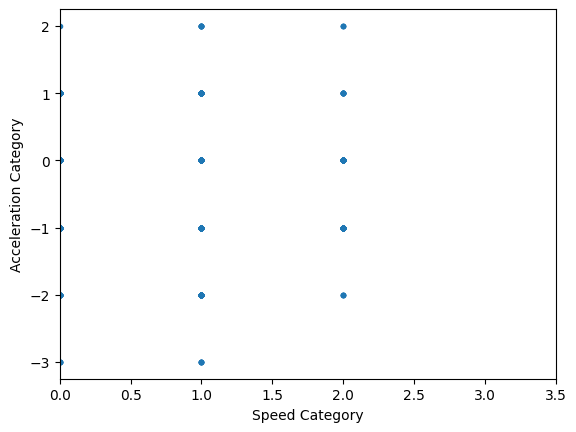

In [16]:
# numeric_col = ['speed','sceneYAcceleration']

# startingDf_copy = firstDf
 
# # Correlation Matrix formation
# corr_matrix = startingDf_copy.loc[:,numeric_col].corr()
# # correlation_matrix = startingDf.corr()
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.scatter(cleanPedDf_copy["Bucket"], cleanPedDf_copy["accBucket"], marker = ".")

plt.xlim(0.0,3.5) 
plt.xlabel('Speed Category')
plt.ylabel('Acceleration Category')
plt.show()


7600

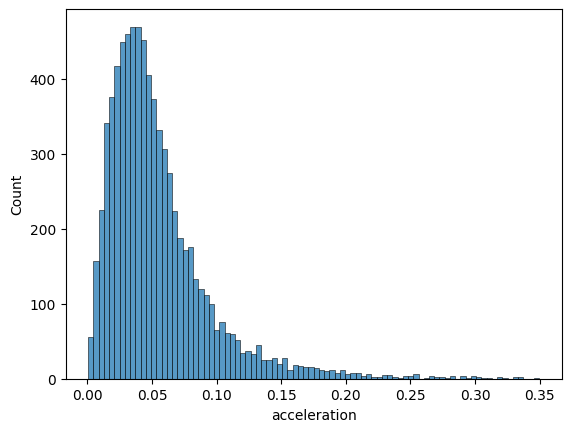

In [17]:
sns.histplot(cleanPedDf_copy["acceleration"])
len(cleanPedDf_copy)

[[6.000e+00 7.000e+00 0.000e+00]
 [1.600e+01 8.600e+01 5.000e+00]
 [4.470e+02 2.865e+03 4.800e+01]
 [5.110e+02 3.370e+03 6.600e+01]
 [3.800e+01 1.100e+02 1.100e+01]
 [1.000e+00 9.000e+00 4.000e+00]]


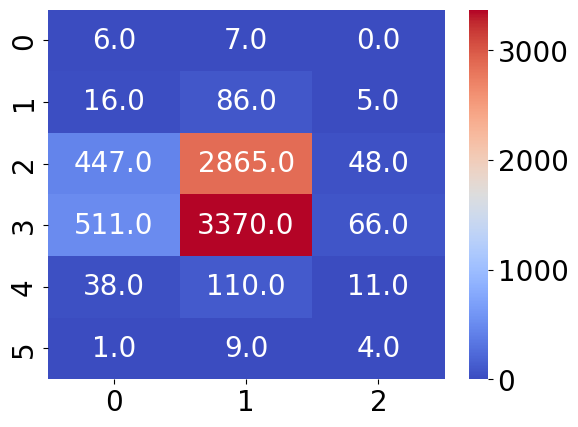

In [18]:
# Generate some example data
plt.rc('font', size=20)
plt.rc('axes', labelsize=10) #fontsize of the x and y labels

NO_OF_BUCKETS = 3

data = np.zeros((2*NO_OF_BUCKETS, NO_OF_BUCKETS))

for index, row in cleanPedDf_copy.iterrows():
    data[cleanPedDf_copy.loc[index, "accBucket"]+NO_OF_BUCKETS][cleanPedDf_copy.loc[index, "Bucket"]] += 1
        
print(data)

# Create a heatmap using Seaborn
sns.heatmap(data, cmap='coolwarm', annot=True, fmt=".1f")

# Show the plot
plt.show()

In [19]:
print(len(cleanPedDf_copy))

7600


# Generation of heatmap:

### Speed and Acceleration heatmap
To show relationship between speed of crossing and acceleration at that speed


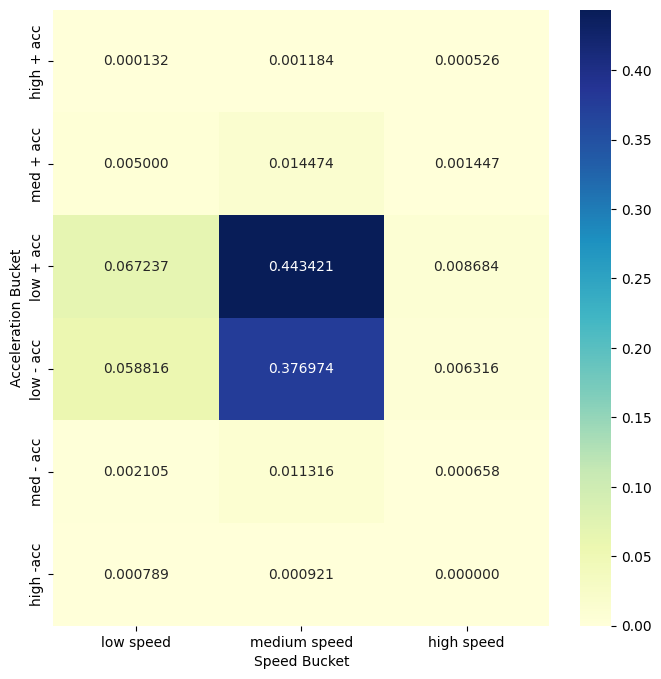

In [21]:
# Generate example data
# data = np.random.rand(3, 3)

def invert_columns(matrix):
    m, n = matrix.shape
    inverted_matrix = np.copy(matrix)  # Create a copy of the original matrix
    
    for j in range(n):
        for i in range(m // 2):
            inverted_matrix[i, j], inverted_matrix[m - 1 - i, j] = inverted_matrix[m - 1 - i, j], inverted_matrix[i, j]

    return inverted_matrix

def assign_category(value_column, num_categories):
    min_value = value_column.min()
    max_value = value_column.max()
    value_range = max_value - min_value
    category_range = value_range / num_categories
    
    def categorize(speed):
        category = int((speed - min_value) / category_range)
        return min(category, num_categories - 1)
    
    categories = value_column.apply(categorize)
    return categories

def assign_category_acc(value_column, num_categories):
    min_value = value_column.min()
    max_value = value_column.max()
    # value_range = max_value - min_value
    pos_category_range = max_value / num_categories
    # print(f"Pos Cat Range = {pos_category_range}")
    neg_category_range = -(min_value) / num_categories
    # print(f"Neg Cat Range = {neg_category_range}")

    
    def categorize(acc):
        if acc > 0:
            category = int(acc / pos_category_range)
            return min(category, num_categories - 1)
        else:
            category = int(acc / neg_category_range)
            return max(category - 1, -num_categories)
    
    categories = value_column.apply(categorize)
    return categories

def heatmapGeneration(NO_OF_BUCKETS, dataFrame):
    
    plt.rc('font', size=10)
    plt.rc('axes', labelsize=10)

    dataFrame["Bucket"] = assign_category(dataFrame["speed"], NO_OF_BUCKETS)
    dataFrame["accBucket"] = assign_category_acc(dataFrame["sceneYAcceleration"], NO_OF_BUCKETS)
    total_length = len(dataFrame)
    total_length

# Create a heatmap using Seaborn
    plt.figure(figsize=(8, 8))
    data = np.zeros((2*NO_OF_BUCKETS, NO_OF_BUCKETS))

    for index, row in dataFrame.iterrows():
        data[dataFrame.loc[index, "accBucket"]+NO_OF_BUCKETS][dataFrame.loc[index, "Bucket"]] += 1

    heatmapData=invert_columns(data)
    sns.heatmap(heatmapData/total_length, annot=True, fmt=".6f", cmap='YlGnBu')

# Customize the axis labels
    plt.xlabel("Speed Bucket")
    plt.ylabel("Acceleration Bucket")

# Customize the tick labels
    x_labels = ["low speed", "medium speed", "high speed"]
    y_labels = ["high + acc", "med + acc", "low + acc", "low - acc", "med - acc", "high -acc"]
    # x_labels = list(range(1, NO_OF_BUCKETS + 1))
    # y_labels = [x for x in range(NO_OF_BUCKETS, - NO_OF_BUCKETS -1, -1) if x != 0]


    plt.xticks(np.arange(0.5, NO_OF_BUCKETS + 0.5, 1), x_labels)
    plt.yticks(np.arange(0.5, 2*NO_OF_BUCKETS + 0.5, 1), y_labels)

# Show the plot
    plt.show()

NO_OF_BUCKETS = 3 
heatmapGeneration(NO_OF_BUCKETS,cleanPedDf)


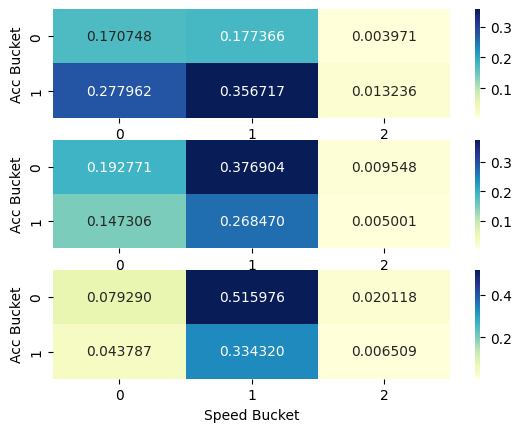

In [36]:
def invert_columns(matrix):
    m, n = matrix.shape
    inverted_matrix = np.copy(matrix)  # Create a copy of the original matrix
    
    for j in range(n):
        for i in range(m // 2):
            inverted_matrix[i, j], inverted_matrix[m - 1 - i, j] = inverted_matrix[m - 1 - i, j], inverted_matrix[i, j]

    return inverted_matrix

def assign_category(value_column, num_categories):
    min_value = value_column.min()
    max_value = value_column.max()
    value_range = max_value - min_value
    category_range = value_range / num_categories
    
    def categorize(speed):
        category = int((speed - min_value) / category_range)
        return min(category, num_categories - 1)
    
    categories = value_column.apply(categorize)
    return categories

def assign_category_acc(value_column, num_categories):
    min_value = value_column.min()
    max_value = value_column.max()
    # value_range = max_value - min_value
    pos_category_range = max_value / num_categories
    # print(f"Pos Cat Range = {pos_category_range}")
    neg_category_range = -(min_value) / num_categories
    # print(f"Neg Cat Range = {neg_category_range}")

    
    def categorize(acc):
        if acc > 0:
            category = int(acc / pos_category_range)
            return min(category, num_categories - 1)
        else:
            category = int(acc / neg_category_range)
            return max(category - 1, -num_categories)
    
    categories = value_column.apply(categorize)
    return categories

def heatmapGenerationDataConfig(NO_OF_BUCKETS, dataFrame):
    
    dataFrame["Bucket"] = assign_category(dataFrame["speed"], NO_OF_BUCKETS)
    dataFrame["accBucket"] = assign_category_acc(dataFrame["sceneYAcceleration"], 1)
    total_length = len(dataFrame)
    total_length

# Create a heatmap using Seaborn
    # plt.figure(figsize=(8, 4))
    data = np.zeros((2, NO_OF_BUCKETS))

    for index, row in dataFrame.iterrows():
        data[dataFrame.loc[index, "accBucket"]+1][dataFrame.loc[index, "Bucket"]] += 1
        
    return data

def heatmapGeneration(NO_OF_BUCKETS, dataFrame, dataFrame1, dataFrame2):

    data = heatmapGenerationDataConfig(NO_OF_BUCKETS, dataFrame)
    data1 = heatmapGenerationDataConfig(NO_OF_BUCKETS, dataFrame1)
    data2 = heatmapGenerationDataConfig(NO_OF_BUCKETS, dataFrame2)
    
    f,(ax1, ax2, ax3) = plt.subplots(3)

    heatmapData=invert_columns(data)
    heatmapData1=invert_columns(data1)
    heatmapData2=invert_columns(data2)
    
    total_length1 = len(dataFrame)
    total_length2 = len(dataFrame1)
    total_length3 = len(dataFrame2)
    
    g1 = sns.heatmap(heatmapData/total_length1, annot=True, fmt=".6f", cmap='YlGnBu', ax=ax1)
    g2 = sns.heatmap(heatmapData1/total_length2, annot=True, fmt=".6f", cmap='YlGnBu',ax=ax2)
    g3 = sns.heatmap(heatmapData2/total_length3, annot=True, fmt=".6f", cmap='YlGnBu', ax=ax3)
    

# Customize the axis labels
    g1.set_xlabel("Speed Bucket")
    g1.set_ylabel("Acc Bucket")
    
    g2.set_xlabel("Speed Bucket")
    g2.set_ylabel("Acc Bucket")
    
    g3.set_xlabel("Speed Bucket")
    g3.set_ylabel("Acc Bucket")

# Customize the tick labels
    # x_labels = ["low speed", "medium speed", "high speed"]
    # # y_labels = ["high + acc", "med + acc", "low + acc", "low - acc", "med - acc", "high -acc"]
    # y_labels = ["positive acc", "negative acc"]
    x_labels = [1,2,3]
    y_labels = [-1,1]


#     ax1.set_xticklabels(np.arange(0.5, 3 + 0.5, 1), x_labels)
#     ax1.set_yticklabels(np.arange(0.5, 2 + 0.5, 1), y_labels)
    
#     ax2.set_xticklabels(np.arange(0.5, 3 + 0.5, 1), x_labels)
#     ax2.set_yticklabels(np.arange(0.5, 2 + 0.5, 1), y_labels)
    
#     ax3.set_xticklabels(np.arange(0.5, 3 + 0.5, 1), x_labels)
#     ax3.set_yticklabels(np.arange(0.5, 2 + 0.5, 1), y_labels)

# Show the plot
    plt.show()

NO_OF_BUCKETS = 3

heatmapGeneration(NO_OF_BUCKETS,startingDf,midDf,endDf)


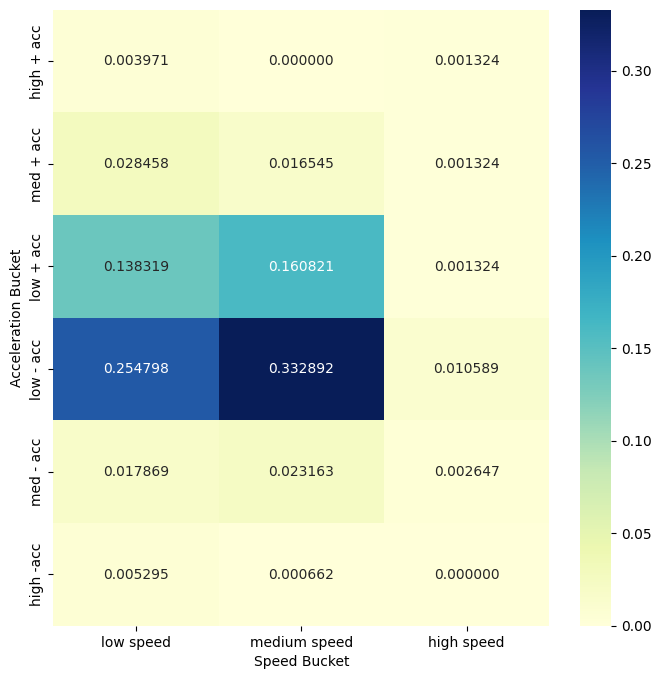

In [22]:
heatmapGeneration(NO_OF_BUCKETS,startingDf)

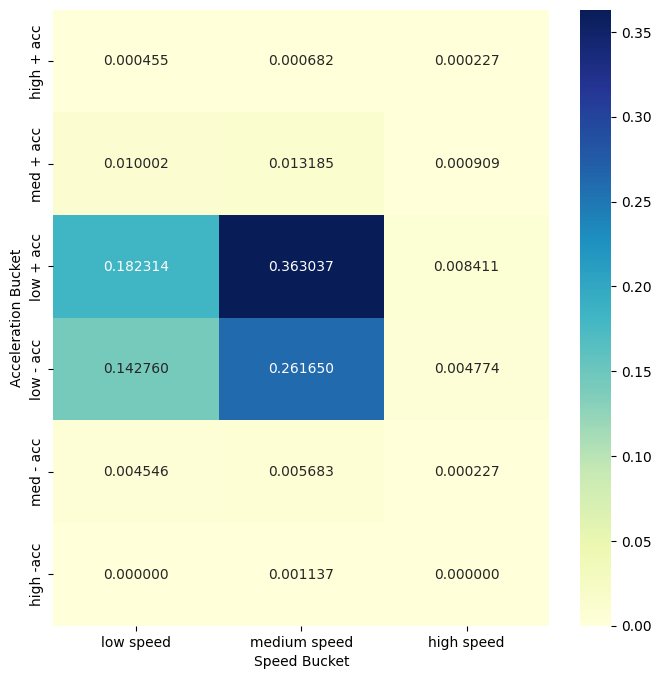

In [23]:
heatmapGeneration(3,midDf)

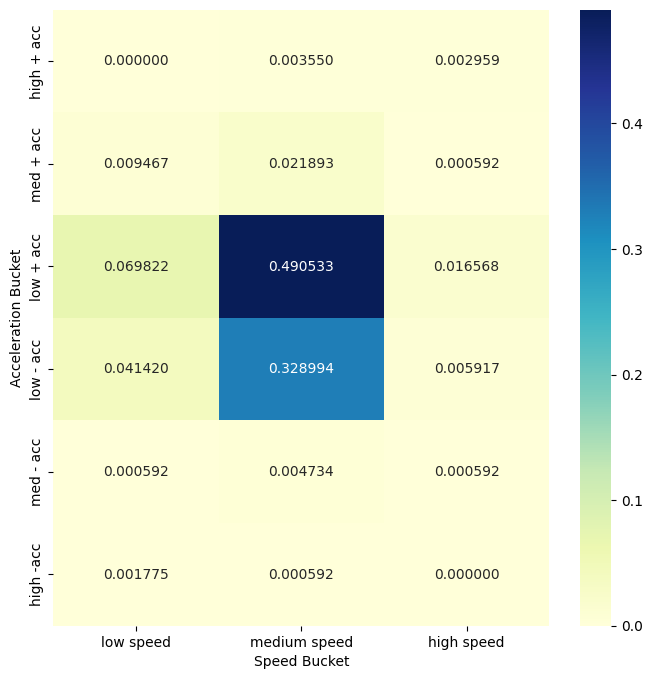

In [24]:
heatmapGeneration(NO_OF_BUCKETS,endDf)

### ADE and speed heatmap

### Testing code 

In [26]:
min_value_speed = cleanPedDf_copy["speed"].min()
max_value_speed = cleanPedDf_copy["speed"].max()
value_range = max_value_speed - min_value_speed
category_range = value_range / NO_OF_CATEGORY
print(f"Speed cat Range = {category_range}")

min_value = cleanPedDf_copy["sceneYAcceleration"].min()
max_value = cleanPedDf_copy["sceneYAcceleration"].max()
# value_range = max_value - min_value
pos_category_range = max_value / NO_OF_CATEGORY
print(f"Pos Cat Range = {pos_category_range}")
neg_category_range = -(min_value) / NO_OF_CATEGORY
print(f"Neg Cat Range = {neg_category_range}")

tempDf = cleanPedDf_copy[(cleanPedDf_copy["speed"] > min_value_speed+category_range) & (cleanPedDf_copy["speed"] < min_value_speed+2*category_range) & (cleanPedDf_copy["sceneYAcceleration"] < pos_category_range) & (cleanPedDf_copy["sceneYAcceleration"] >= 0)]

Speed cat Range = 0.30947310850614834
Pos Cat Range = 0.07852426787155291
Neg Cat Range = 0.10898178797216956


In [27]:
tempDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,Bucket,accBucket
27,18,804,18023,210,5.0,0.889504,-0.176444,-0.107957,0.499586,0.016608,0.028387,0.511117,0.260104,2.631298,0.032888,-0.260104,2.631298,1,0
28,18,806,18023,210,5.0,0.909839,-0.274597,-0.101676,0.490764,-0.031406,0.044112,0.501186,0.280439,2.729451,0.054150,-0.280439,2.729451,1,0
190,18,4194,18069,210,5.0,0.731066,1.500790,-0.115381,0.635455,-0.077176,0.000276,0.645845,0.101666,0.954064,0.077177,-0.232366,0.986353,1,0
191,18,4196,18069,210,5.0,0.752258,1.374259,-0.105959,0.632656,-0.047108,0.013996,0.641467,0.122858,1.080595,0.049143,-0.253558,1.112884,1,0
192,18,4198,18069,210,5.0,0.773376,1.248429,-0.105590,0.629149,-0.001845,0.017533,0.637948,0.143976,1.206425,0.017630,-0.274676,1.238714,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25882,29,28090,29534,210,5.0,0.626977,-1.565006,-0.171918,0.675933,-0.000436,0.000350,0.697454,0.002423,4.019860,0.000559,-0.874372,3.939596,1,0
25883,29,28092,29534,210,5.0,0.661564,-1.698682,-0.172934,0.668378,0.005078,0.037778,0.690387,0.032164,4.153535,0.038118,-0.908959,4.073271,1,0
25885,29,28096,29534,210,5.0,0.735649,-1.965220,-0.188894,0.662203,0.036809,0.041421,0.688618,0.106249,4.420074,0.055413,-0.983044,4.339810,1,0
25886,29,28098,29534,210,5.0,0.774385,-2.095974,-0.193679,0.653773,0.023924,0.042154,0.681858,0.144985,4.550828,0.048470,-1.021780,4.470564,1,0


In [28]:
tempDf[tempDf["accBucket"] == 0]

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,Bucket,accBucket
27,18,804,18023,210,5.0,0.889504,-0.176444,-0.107957,0.499586,0.016608,0.028387,0.511117,0.260104,2.631298,0.032888,-0.260104,2.631298,1,0
28,18,806,18023,210,5.0,0.909839,-0.274597,-0.101676,0.490764,-0.031406,0.044112,0.501186,0.280439,2.729451,0.054150,-0.280439,2.729451,1,0
190,18,4194,18069,210,5.0,0.731066,1.500790,-0.115381,0.635455,-0.077176,0.000276,0.645845,0.101666,0.954064,0.077177,-0.232366,0.986353,1,0
191,18,4196,18069,210,5.0,0.752258,1.374259,-0.105959,0.632656,-0.047108,0.013996,0.641467,0.122858,1.080595,0.049143,-0.253558,1.112884,1,0
192,18,4198,18069,210,5.0,0.773376,1.248429,-0.105590,0.629149,-0.001845,0.017533,0.637948,0.143976,1.206425,0.017630,-0.274676,1.238714,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25882,29,28090,29534,210,5.0,0.626977,-1.565006,-0.171918,0.675933,-0.000436,0.000350,0.697454,0.002423,4.019860,0.000559,-0.874372,3.939596,1,0
25883,29,28092,29534,210,5.0,0.661564,-1.698682,-0.172934,0.668378,0.005078,0.037778,0.690387,0.032164,4.153535,0.038118,-0.908959,4.073271,1,0
25885,29,28096,29534,210,5.0,0.735649,-1.965220,-0.188894,0.662203,0.036809,0.041421,0.688618,0.106249,4.420074,0.055413,-0.983044,4.339810,1,0
25886,29,28098,29534,210,5.0,0.774385,-2.095974,-0.193679,0.653773,0.023924,0.042154,0.681858,0.144985,4.550828,0.048470,-1.021780,4.470564,1,0


In [29]:
# import numpy as np

def invert_columns(matrix):
    m, n = matrix.shape
    inverted_matrix = np.copy(matrix)  # Create a copy of the original matrix
    
    for j in range(n):
        for i in range(m // 2):
            inverted_matrix[i, j], inverted_matrix[m - 1 - i, j] = inverted_matrix[m - 1 - i, j], inverted_matrix[i, j]

    return inverted_matrix

# Example matrix
original_matrix = np.array([[1, 2, 3],
                            [4, 5, 6],
                            [7, 8, 9]])

inverted_matrix = invert_columns(original_matrix)
print("Original Matrix:")
print(original_matrix)

print("\nInverted Matrix:")
print(inverted_matrix)


Original Matrix:
[[1 2 3]
 [4 5 6]
 [7 8 9]]

Inverted Matrix:
[[7 8 9]
 [4 5 6]
 [1 2 3]]


Startingsection: Pedestrians speed up or slows down.


In [34]:
Hypotest1Df = startingDf[(startingDf["sceneYAcceleration"] > 0)]
print(len(Hypotest1Df))

532


In [21]:
array = list(range(1, 3+1))
print(array)

[1, 2, 3]
